In [142]:
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph.message import add_messages

from dotenv import load_dotenv
from langsmith import Client

load_dotenv()
client = Client()

In [143]:
class RealEstateState(TypedDict): # 그래프의 상태를 정의하는 클래스
    real_estate_type: Annotated[str ,"부동산 유형 (예: 아파트, 상가)"]
    keywordlist: Annotated[List[Dict] ,"키워드 리스트"]
    messages: Annotated[list, add_messages]
    query_sql: Annotated[str ,"생성된 SQL 쿼리"]
    results: Annotated[List[Dict], "쿼리 결과"]
    answers: Annotated[List[str], "최종 답변 결과"]
    query_answer:Annotated[str, 'answer다듬기']

In [144]:
from langgraph.graph import StateGraph, START, END
from langchain_openai.chat_models.base import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

# Step 1: LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

# Step 2: StateGraph 정의
workflow = StateGraph(RealEstateState)

In [145]:
def filter_node(state:RealEstateState) -> RealEstateState:
    system_prompt = """
    Classify if a given question is related to real estate. If the question is related to topics such as property transactions, rental conditions, location recommendations, or property features, return Pass. If it's not directly related to real estate, return Fail.

    # Output Format
    - Return Pass if the question is real estate-related, otherwise return Fail.

    # Examples
    - 입력: '서울 아파트 매매 가격이 어떻게 되나요?'
      출력: Pass

    - 입력: '이 동네 전세 시세 알려주세요'
      출력: Pass

    - 입력: '서울에서 월세 계약 조건이 어떻게 되나요?'
      출력: Pass

    - 입력: '서울 아파트 매매가 얼마인가요?'
      출력: Pass

    - 입력: '대치동에서 버스정류장과 지하철이 가장 가까운 곳으로 알려줘'
      출력: Pass

    - 입력: '여자 혼자 살기 좋은 곳 추천해줘'
      출력: Pass

    - 입력: '교통이 편리하고 저렴한 원룸 추천해줘'
      출력: Pass

    - 입력: '이 음식점이 맛있나요?'
      출력: Fail

    - 입력: '서울에서 가장 큰 공원이 어디인가요?'
      출력: Fail
    """
    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(state["messages"][-1].content)
    ])

    real_estate_type = response.content.strip()
    return RealEstateState(real_estate_type=real_estate_type)

In [146]:
def fiter_router(state: RealEstateState):
    # This is the router
    real_estate_type = state["real_estate_type"]
    if real_estate_type == "Pass":
        return "Pass"
    else:
        return 'Fail'

In [147]:
def re_questions(state: RealEstateState) -> RealEstateState:
    print("=================================")
    print("""[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.
          부동산 관련 질문을 좀 더 자세하게 작성해주시면 답변드리겠습니다!!!""")
    new_question = input("새로운 부동산 질문을 입력해주세요: ")
    print("=================================")
    # 수정된 질문을 state에 업데이트
    return RealEstateState(messages=new_question)

In [148]:
import json

def extract_keywords_based_on_db(state: RealEstateState) -> RealEstateState:
    system_prompt = """
    Extract relevant keywords from a user's question based on the database schema. Match the keywords to the following categories and their corresponding tables/columns:

    1. **Location**:
    - Table: `Location`
    - Columns: `sido`, `sigungu`, `dong`

    2. **Property Type**:
    - Table: `Property`
    - Column: `property_type` (e.g., apartment, villa, officetel)

    3. **Price**:
    - Tables: `Sale`, `Rental`
    - Columns: `price`, `deposit`, `monthly_rent`

    4. **Transaction Type**:
    - Tables: `Sale`, `Rental`
    - Columns: `rental_type` (e.g., 매매, 전세, 월세)

    5. **Property Features**:
    - Table: `Property`
    - Columns: `room_count`, `bathroom_count`, `parking_count`, `exclusive_area`, `floor`

    6. **User Preferences**:
    - Table: `User`
    - Columns: `desired_location`, `age`, `gender`

    7. **Cultural/Facilities**:
    - Tables: `Cultural Facility`, `Cultural Festival`
    - Columns: `facility_name`, `festival_name`

    8. **Safety and Crime Data**:
    - Table: `Crime Stats`
    - Columns: `crime_category`, `crime_rate`

    # Output Format
    Return the extracted keywords in JSON format with the following keys:
    - "Location"
    - "Property Type"
    - "Price"
    - "Transaction Type"
    - "Property Features"
    - "User Preferences"
    - "Cultural/Facilities"
    - "Safety and Crime Data"

    If a category is not mentioned, return "없음".

    # Examples
    - Input: "서울 강남구에 있는 3억 이하 전세 아파트 찾아줘"
    Output: {
        "Location": "서울 강남구",
        "Property Type": "아파트",
        "Price": "3억 이하",
        "Transaction Type": "전세",
        "Property Features": "없음",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "없음"
    }

    - Input: "용산구에서 안전한 주택 찾고 싶어요"
    Output: {
        "Location": "용산구",
        "Property Type": "주택",
        "Price": "없음",
        "Transaction Type": "없음",
        "Property Features": "없음",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "안전"
    }

    - Input: "화장실 2개, 방 3개 있는 집 알려줘"
    Output: {
        "Location": "없음",
        "Property Type": "없음",
        "Price": "없음",
        "Transaction Type": "없음",
        "Property Features": "화장실 2개, 방 3개",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "없음"
    }
    """

    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=state["messages"][-1].content)
    ])
    
    extracted_keywords = response.content.strip()
    result = json.loads(extracted_keywords)
    return RealEstateState(keywordlist=result)



In [149]:
def re_questions_keywords(state: RealEstateState) -> RealEstateState:
    
    user_keywords = state["keywordlist"]
    
    if user_keywords["Location"] == "없음":
        print("=================================")
        print("""[re_questions_keywords] 질문에 지역정보가 없습니다!!! 지역 정보를 포함하여 써주시면 더 좋은 답변을 드립니다!!""")
        new_question = input("새로운 부동산 질문을 입력해주세요: ")
        print("=================================")
        return RealEstateState(messages=new_question)
    
    elif user_keywords["Transaction Type"] == "없음":
        print("=================================")
        print("""[re_questions_keywords] 질문에 부동산 유형 정보(매매, 전세, 월세)가 없습니다!!! 부동산 유형 정보를 포함하여 써주시면 더 좋은 답변을 드립니다!!""")
        new_question = input("새로운 부동산 질문을 입력해주세요: ")
        print("=================================")
        return RealEstateState(messages=new_question)
    
    elif user_keywords['Price'] == '없음':
        print("=================================")
        print("""[re_questions_keywords] 질문에 가격 정보가 없습니다!!! 가격 정보를 포함하여 써주시면 더 좋은 답변을 드립니다!!""")
        new_question = input("새로운 부동산 질문을 입력해주세요: ")
        print("=================================")
        return RealEstateState(messages=new_question)

In [150]:
def keyword_router(state: RealEstateState)-> RealEstateState: 
    # This is the router
    user_keywords = state["keywordlist"]
    
    if user_keywords['Location'] != "없음" and user_keywords['Transaction Type'] != "없음" and user_keywords['Price'] != "없음":
        if user_keywords['Transaction Type'] == '매매':
            return '매매'
        elif user_keywords['Transaction Type'] == '전세':
            return '전세'
        else:
            return '월세'
    else:
        return 'Fail'

In [151]:
import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_db_engine(db_path):
    """로컬 SQLite DB 파일과 연결된 엔진을 생성합니다."""
    try:
        # SQLite DB 파일과 연결
        connection = sqlite3.connect(db_path, check_same_thread=False)
        # SQLAlchemy 엔진 생성
        engine = create_engine(
            f"sqlite:///{db_path}",
            poolclass=StaticPool,
            connect_args={"check_same_thread": False}
        )
        return engine
    except Exception as e:
        print(f"데이터베이스 연결 중 오류 발생: {str(e)}")
        return None
    
    
# DB 파일 경로 지정
db_path = './data/real_estate_(1).db'
engine = get_db_engine(db_path)
db = SQLDatabase(
    engine,
    sample_rows_in_table_info=False  # 샘플 행 조회 비활성화
)


In [1]:
base_prompt = """
다음 데이터베이스 구조를 기반으로 사용자의 질문에 대한 SQL 쿼리를 생성해주세요:

사용가능한 데이터 베이스 스키마:
{table}

주의사항:
1. 관련 조건은 SQL WHERE 절 형식으로 작성해주세요.
2. SQL 쿼리를 작성할 때는 명확하고 효율적이어야 합니다.
3. 결과는 최대 {top_k}개까지만 보여주세요.
4. 금액에 관련된 쿼리를 작성할 때는 쉼표(,)를 제거하고 숫자로 변환해야 합니다. 가능하다면, `WITH` 절 또는 서브쿼리를 사용하여 필드를 미리 변환하고 가독성을 높이세요.
5. 에러가 발생하면 원인을 설명하고 수정된 쿼리를 제시해주세요.
6. 텍스트 검색에는 LIKE 또는 MATCH ... AGAINST를 활용하세요.
7. 여러 조건은 AND 또는 OR로 연결하세요.
8. 정렬, 그룹화 등이 필요한 경우 이를 추가로 명시하세요. 예: ORDER BY created_at DESC.
9. 매물들을 정렬할 때 우선순위는 위치(1순위), 가격(2순위) 순 입니다.
10. 쿼리만 작성하고 추가 설명은 하지 마세요.
11. facilities는 영어로 쳐야지 나옵니다.
    - pi.facilities LIKE '%ELEVATOR%' -> 엘리베이터
    - pi.facilities LIKE '%aircon%' -> 에이컨, 에어콘
12. 매물번호도 함께 보여주세요 매물번호는 property_id입니다.

13. 지하철역에 관한 정보는 addresses 테이블의 area_name 칼럼에 있습니다.
    - addresses.area_name LIKE '%강남역%' -> 강남역
14. subway_stations 테이블에는 지하철역이 아닌 지하철이 몇호선인지가 담겨있습니다.
15. subway_stations 테이블은 지하철 호선을 묻는 것이 아닌 이상 사용하지마시오.
16. "역세권"은 location_distances 테이블의 distance를 사용하면 됩니다.
    - location_distances.distance <= 1000 -> "역세권"
"""

In [2]:
rentals_prompt = """
17. rental_type 값은 다음과 같습니다:
    - 'MONTHLY': 전세
    - 'YEARLY': 월세
18. rentals 테이블에 price라는 컬럼이 없습니다. rentals 테이블에는 price 대신 deposit(보증금)과 monthly_rent(월세) 컬럼이 존재합니다.

### 예시 질문과 쿼리:

- 질문: "서울시 강남구 보증금 2000에 월세 70짜리 추천해줘"

```sql
SELECT 
    r.property_id,
    pi.description,
    pi.facilities,
    r.deposit AS "보증금",
    r.monthly_rent AS "월세비",
FROM rentals r
JOIN property_info pi ON r.property_id = pi.property_id
JOIN property_locations l ON pi.property_location_id = l.property_location_id
WHERE l.sigungu LIKE '%강남구%'
AND r.rental_type = 'YEARLY'
AND CAST(REPLACE(r.deposit, ',', '') AS INTEGER) <= 20000000
AND CAST(REPLACE(r.monthly_rent, ',', '') AS INTEGER) <= 700000;
'''

- 질문: "강남역 역세권 전세 10억 추천해줘"

```sql
SELECT DISTINCT 
    r.property_id,
    pi.description,
    pi.facilities,
    r.deposit AS "보증금"
FROM rentals r
JOIN property_info pi ON r.property_id = pi.property_id
JOIN property_locations l ON pi.property_location_id = l.property_location_id
WHERE l.sigungu LIKE '%강남구%'
  AND r.rental_type = 'MONTHLY'
  AND CAST(REPLACE(r.deposit, ',', '') AS INTEGER) <= 100000000;
'''

사용자 질문: {user_query}
"""

In [152]:
def rental_monthly(state: RealEstateState) -> RealEstateState:
    table = db.get_table_info(table_names=["rentals", "property_info", "property_locations"])

    prompt = base_prompt + rentals_prompt

    prompt = prompt.format(
        table = table,
        top_k=5,
        user_query=state['messages'][-1].content
    )

    response = llm.invoke([
        SystemMessage(content="당신은 SQLite Database  쿼리를 생성하는 전문가입니다."),
        HumanMessage(prompt)
    ])

    llm_query = response.content
    

    return RealEstateState(query_sql=llm_query)

In [153]:
def rental(state: RealEstateState) -> RealEstateState:
    rentals = db.get_table_info(table_names=["rentals", "property_info", "property_locations"])

    rental_prompt = """
    사용 가능한 테이블 스키마:
    {rentals}

    당신은 SQL 전문가입니다. 
    데이터베이스는 {dialect} 방언을 사용합니다.

    다음 규칙을 따라주세요:
        1. 한국어로 응답해주세요.
        2. SQL 쿼리를 작성할 때는 명확하고 효율적이어야 합니다.
        3. 결과는 최대 {top_k}개까지만 보여주세요.
        4. 금액에 관련된 쿼리를 작성할 때는 쉼표(,)를 제거하고 숫자로 변환해야 합니다.
        5. 에러가 발생하면 원인을 설명하고 수정된 쿼리를 제시해주세요.
        6. rental_type 값은 다음과 같습니다:
        - 'MONTHLY': 전세
        - 'YEARLY': 월세
        7. 반드시 SELECT문에 포함되어야 하는 필드는 다음과 같습니다:
        - `r.property_id` (매물번호)
        - `l.sigungu` (시/군/구)
        - `p.description` (부동산 설명)
        - `r.deposit` (보증금)
        - `l.latitude` (위도)
        - `l.longitude` (경도)
        8. 필요한 경우 조건을 추가로 명시하세요:
        - 지역 (l.sigungu, l.dong)
        - 가격 조건 (r.deposit, r.monthly_rent)
        - 거래 유형 (r.rental_type)
        - 기타 사용자 요청 사항 (e.g., 방 개수, 전용 면적)
        9. rental_type 값이 없는 경우 전체 결과를 반환하지만, 사용자가 조건을 명시했으면 해당 조건을 반드시 반영하세요.
        10. 결과가 없을 경우 적절한 이유를 설명하고 대체 쿼리를 작성하세요.
        11. '전세', '월세' 등의 거래 조건에 따라 적절히 필터링하세요.
        12. `CAST(... AS DECIMAL)` 대신 `CAST(... AS INTEGER)`를 사용하세요.
        13. 별도의 멘트 없이 **오직 SQL 쿼리만** 작성하세요.

    ### 예시 질문과 쿼리:

    - 질문: "서울시 강남구 10억 이하 전세를 추천해줘"

    ```sql
    SELECT 
        r.property_id,
        l.sigungu,
        p.description,
        r.deposit AS "보증금",
        l.latitude,
        l.longitude
    FROM rentals r
    JOIN property_info p ON r.property_id = p.property_id
    JOIN property_locations l ON p.property_location_id = l.property_location_id
    WHERE l.sigungu LIKE '%강남구%'
    AND r.rental_type = 'MONTHLY'
    AND CAST(REPLACE(r.deposit, ',', '') AS INTEGER) <= 100000000
    ORDER BY ABS(CAST(REPLACE(r.deposit, ',', '') AS INTEGER) - 100000000) ASC
    LIMIT 5;
    '''

    """
    prompt = rental_prompt.format(
        dialect="SQLite",
        top_k=5,
        rentals=rentals,
    )

    response = llm.invoke([
        SystemMessage(content=prompt),
        HumanMessage(state["messages"][-1].content)
    ])

    llm_query = response.content
    

    return RealEstateState(query_sql=llm_query)

In [154]:
def sales(state: RealEstateState) -> RealEstateState:
    sales = db.get_table_info(table_names=["sales", "property_info", "property_locations"])

    rental_prompt = """
    사용 가능한 테이블 스키마:
    {sales}

    당신은 SQL 전문가입니다. 
    데이터베이스는 {dialect} 방언을 사용합니다.

    다음 규칙을 따라주세요:
        1. 한국어로 응답해주세요.
        2. SQL 쿼리를 작성할 때는 명확하고 효율적이어야 합니다.
        3. 결과는 최대 {top_k}개까지만 보여주세요.
        4. 금액에 관련된 쿼리를 작성할 때는 쉼표(,)를 제거하고 숫자로 변환해야 합니다.
        5. 에러가 발생하면 원인을 설명하고 수정된 쿼리를 제시해주세요.
        6. 반드시 SELECT문에 포함되어야 하는 필드는 다음과 같습니다:
        - `s.property_id` (매물번호)
        - `l.sigungu` (시/군/구)
        - `p.description` (부동산 설명)
        - `s.price` (가격)
        - `l.latitude` (위도)
        - `l.longitude` (경도)
        7. 필요한 경우 조건을 추가로 명시하세요:
        - 지역 (l.sigungu, l.dong)
        - 가격 조건 (s.price)
        - 기타 사용자 요청 사항 (e.g., 방 개수, 전용 면적)
        8. 결과가 없을 경우 적절한 이유를 설명하고 대체 쿼리를 작성하세요.
        9. `CAST(... AS DECIMAL)` 대신 `CAST(... AS INTEGER)`를 사용하세요.
        10. 별도의 멘트 없이 **오직 SQL 쿼리만** 작성하세요.

    ### 예시 질문과 쿼리:

    - 질문: "서울시 강남구 10억 이하 매매를 추천해줘"

    ```sql
    SELECT 
        s.property_id,
        l.sigungu,
        p.description,
        s.price AS "보증금",
        l.latitude,
        l.longitude
    FROM sales s
    JOIN property_info p ON s.property_id = p.property_id
    JOIN property_locations l ON p.property_location_id = l.property_location_id
    WHERE l.sigungu LIKE '%강남구%'
    AND CAST(REPLACE(s.price, ',', '') AS INTEGER) <= 100000000
    ORDER BY ABS(CAST(REPLACE(s.price, ',', '') AS INTEGER) - 100000000) ASC
    LIMIT 5;
    '''

    """
    prompt = rental_prompt.format(
        dialect="SQLite",
        top_k=5,
        sales=sales,
    )

    response = llm.invoke([
        SystemMessage(content=prompt),
        HumanMessage(state["messages"][-1].content)
    ])

    llm_query = response.content
    

    return RealEstateState(query_sql=llm_query)

In [155]:
def clean_sql_response(state: RealEstateState) -> RealEstateState:
    # 'query_sql' 키는 항상 존재한다고 가정
    query_sql = state['query_sql']

    # 코드 블록(````sql ... `````) 제거
    if query_sql.startswith("```sql") and query_sql.endswith("```"):
        query_sql = query_sql[6:-3].strip()  # "```sql" 제거 후 앞뒤 공백 제거

    # SQL 문 끝에 세미콜론 추가 (필요시)
    if not query_sql.strip().endswith(";"):
        query_sql = query_sql.strip() + ";"
        

    # 상태 업데이트
    return RealEstateState(query_sql=query_sql)

In [156]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def run_query(state: RealEstateState) -> RealEstateState:
    
    tool = QuerySQLDataBaseTool(db=db)
    results = tool._run(state["query_sql"])

    return RealEstateState(results=results)

In [157]:
def rental_monthly_answer(state: RealEstateState) -> RealEstateState:
    input = state["results"]

    if len(input) == 0:
        return RealEstateState(answers="검색 결과가 없습니다.")

    answer_prompt = """
    Convert the provided string-formatted data into a JSON structure that includes separate grouping for specific attributes.

    Given input strings, parse and transform them into a JSON format. Group the information into relevant sections as specified: one for general attributes, one for latitude and one for longitude.

    # Steps

    1. Parse the input string into its constituent components.
    - Break down the input string to extract individual property details such as description, deposit, Latitude, and Longitude.
    2. Extract and organize the data into four key fields:
    - "description": A textual representation of the property features and details.
    - "deposit": The deposit amount in a user-friendly format (e.g., including currency units).
    - "monthly_rent": 
    - "Latitude": The latitude coordinate of the property (numeric).
    - "Longitude": The longitude coordinate of the property (numeric).
    3. Store the extracted details in a JSON object with a unique key for each property (e.g., "매물_1", "매물_2").

    # Example

    **Input**:
    ```
    #### 매물 1
    - **보증금:** 500,000원
    - **월세:**  350,000원
    - **특징:**
    - 살기 편한 원룸입니다.
    - 보증금 부담없이 최소3개월부터 장기계약 가능합니다.
    - 언제든지 보실 수 있습니다.
    - 전화주시면 친절히 안내해드리겠습니다.
    - 반지층이지만 뽀송뽀송합니다
    - **위치:** 
    - **위도:** 37.627433
    - **경도:** 127.0251222

    ---

    ### 매물 2
    - **보증금:** 1,000,000원
    - **월세:** 350,000원
    - **특징:**
    - ■ 우이동 + 쌍문동 토마토부동산
    - ■ 02.905.1356 | 010.7518.1356
    - ■ 카카오 ID : 1356tomato
    - ━━━━━━━━━━━━━━━
    - ■ 매물 설명
    - 덕성여대 후문에서 걸어서 5분
    - 우이경전철 4.19민주묘지역에서 걸어서 5분
    - 냉장고, 세탁기, 전자렌지 등 풀 옵션
    - 덕성여대 학생 환영
    - 깔끔한 인테리어 자랑
    - CCTV 등 안전한 보안 시스템
    - 보증금 100만 원에 월 35만 원
    - 관리비 5만 원 별도
    - **위치:**
    - **위도:** 37.654518
    - **경도:** 127.0123172
    ```

    **Output**:
    ```json
    {
        "매물_1": {
            "description": "살기 편한 원룸입니다. 보증금 부담 없이 최소 3개월부터 장기 계약 가능합니다. 언제든지 보실 수 있습니다. 전화주시면 친절히 안내해드리겠습니다. 반지층이지만 뽀송뽀송합니다.",
            "deposit": "500,000원",
            "monthly_rent": "350,000원",
            "Latitude": 37.627433,
            "Longitude": 127.0251222
        },
        "매물_2": {
            "description": "덕성여대 후문에서 걸어서 5분. 우이경전철 4.19민주묘지역에서 걸어서 5분. 냉장고, 세탁기, 전자렌지 등 풀 옵션. 덕성여대 학생 환영. 깔끔한 인테리어 자랑. CCTV 등 안전한 보안 시스템. 보증금 100만 원에 월 35만 원. 관리비 5만 원 별도.",
            "deposit": "1,000,000원",
            "monthly_rent": "350,000원",
            "Latitude": 37.654518,
            "Longitude": 127.0123172
        }
    }


    ```

    # Notes

    - Ensure that the JSON keys and structure adhere strictly to the specified format.
    - The description in the general attributes should be a single string concatenating all features.
    - The deposit amount should preserve its unit (e.g., 원 in this case).
    """

    response = llm.invoke([SystemMessage(content=answer_prompt),
                           HumanMessage(content=input)])

    output = response.content.strip()


    return RealEstateState(answers=output)

In [158]:
def rental_answer(state: RealEstateState) -> RealEstateState:
    input = state["results"]

    if len(input) == 0:
        return RealEstateState(answers="검색 결과가 없습니다.")

    answer_prompt = """
    Convert the provided string-formatted data into a JSON structure that includes separate grouping for specific attributes.

    Given input strings, parse and transform them into a JSON format. Group the information into relevant sections as specified: one for general attributes, one for latitude and one for longitude.

    # Steps

    1. Parse the input string into its constituent components.
    - Break down the input string to extract individual property details such as description, deposit, Latitude, and Longitude.
    2. Extract and organize the data into four key fields:
    - "description": A textual representation of the property features and details.
    - "deposit": The deposit amount in a user-friendly format (e.g., including currency units).
    - "Latitude": The latitude coordinate of the property (numeric).
    - "Longitude": The longitude coordinate of the property (numeric).
    3. Store the extracted details in a JSON object with a unique key for each property (e.g., "매물_1", "매물_2").

    # Example

    **Input**:
    ```
    #### 매물 1
    - **가격:** 80,000,000원
    - **특징:**
    - 도배, 장판, 싱크대 교체
    - 방 2개 모두 넓음
    - 주방 겸 거실, 욕실, 방 2개 구조
    - 12월 6일 이후 입주 가능
    - 1층 비슷한 반지하로 채광 및 통풍이 좋음
    - 내부 컨디션 굿
    - **위치:** 
    - **위도:** 37.4743208
    - **경도:** 127.0499473
    - **상담 안내:** 방문 전 전화 주시면 친절히 상담해 드립니다.

    ---

    ### 매물 2
    - **가격:** 80,000,000원
    - **특징:**
    - 양재역 세권의 조용한 주거지역
    - 시세 대비 저렴
    - 즉시 입주 가능
    - 상태 깨끗
    - 반려동물 및 주차는 불가
    - 전세 대출 가능
    - 반전세도 가능
    - **위치:**
    - **위도:** 37.4864957
    - **경도:** 127.0387469
    ```

    **Output**:
    ```json
    {
        "매물_1": {
            "description": "도배, 장판, 싱크대 교체, 방 2개 모두 넓음, 주방 겸 거실, 욕실, 방 2개 구조, 12월 6일 이후 입주 가능, 1층 비슷한 반지하로 채광 및 통풍이 좋음, 내부 컨디션 굿",
            "deposit": "80,000,000원",
            "Latitude": 37.4864957,
            "Longitude": 127.0387469
        },
        "매물_2": {
            "description": "양재역 세권의 조용한 주거지역, 시세 대비 저렴, 즉시 입주 가능, 상태 깨끗, 반려동물 및 주차는 불가, 전세 대출 가능, 반전세도 가능",
            "deposit": "80,000,000원",
            "Latitude": 37.4864957,
            "Longitude": 127.0387469
        }
    }

    ```

    # Notes

    - Ensure that the JSON keys and structure adhere strictly to the specified format.
    - The description in the general attributes should be a single string concatenating all features.
    - The deposit amount should preserve its unit (e.g., 원 in this case).
    """

    response = llm.invoke([SystemMessage(content=answer_prompt),
                           HumanMessage(content=input)])

    output = response.content.strip()


    return RealEstateState(answers=output)

In [159]:
def sale_answer(state: RealEstateState) -> RealEstateState:
    input = state["results"]

    if len(input) == 0:
        return RealEstateState(answers="검색 결과가 없습니다.")

    answer_prompt = """
    Convert the provided string-formatted data into a JSON structure that includes separate grouping for specific attributes.

    Given input strings, parse and transform them into a JSON format. Group the information into relevant sections as specified: one for general attributes, one for latitude and one for longitude.

    # Steps

    1. Parse the input string into its constituent components.
    - Break down the input string to extract individual property details such as description, price, Latitude, and Longitude.
    2. Extract and organize the data into four key fields:
    - "description": A textual representation of the property features and details.
    - "price": The deposit amount in a user-friendly format (e.g., including currency units).
    - "Latitude": The latitude coordinate of the property (numeric).
    - "Longitude": The longitude coordinate of the property (numeric).
    3. Store the extracted details in a JSON object with a unique key for each property (e.g., "매물_1", "매물_2").

    # Example

    **Input**:
    ```
    #### 매물 1
    - **가격:** 480,000,000원
    - **특징:**
    -. 3달전 리모델링 매우 깔끔
    -. 도보 10분 내 초, 중, 고등학교 최고의 학세권
    -. 방 4, 화장실 2, 드래스 룸, 넓고 큰 발코니
    -. 남동향이라 채광 및 햇살 good
    -. 일부 가격조정 가능
    - **위치:** 
    - **위도:** 37.5578514
    - **경도:** 126.9440271

    ---

    ### 매물 2
    - **가격:** 435,000,000원
    - **특징:**
    - 로얄층 전세안고 저렴한 가격에 매매
    - 선호도가 좋은 라인입니다'
    - **위치:**
    - **위도:** 37.5482264
    - **경도:** 126.9453479
    ```

    **Output**:
    ```json
    {
        "매물_1": {
            "description": "3달전 리모델링 매우 깔끔, 도보 10분 내 초, 중, 고등학교 최고의 학세권, 방 4, 화장실 2, 드래스 룸, 넓고 큰 발코니, 남동향이라 채광 및 햇살 good, 일부 가격조정 가능",
            "price": "480,000,000원",
            "Latitude": 37.5578514,
            "Longitude": 126.9440271
        },
        "매물_2": {
            "description": "로얄층 전세안고 저렴한 가격에 매매, 선호도가 좋은 라인입니다",
            "price": "435,000,000원",
            "Latitude": 37.5482264,
            "Longitude": 126.9453479
        }
    }

    ```

    # Notes

    - Ensure that the JSON keys and structure adhere strictly to the specified format.
    - The description in the general attributes should be a single string concatenating all features.
    - The deposit amount should preserve its unit (e.g., 원 in this case).
    """

    response = llm.invoke([SystemMessage(content=answer_prompt),
                           HumanMessage(content=input)])

    output = response.content.strip()


    return RealEstateState(answers=output)

In [160]:
def answer_router(state: RealEstateState)-> RealEstateState: 
    # This is the router
    user_keywords = state["keywordlist"]
    
    if user_keywords['Transaction Type'] == '매매':
        return '매매'
    elif user_keywords['Transaction Type'] == '전세':
        return '전세'
    else:
        return '월세'

In [161]:
def clean_answer_response(state: RealEstateState) -> RealEstateState:
    # 'query' 키는 항상 존재한다고 가정
    query = state['answers']

    if query == "검색 결과가 없습니다.":
        return RealEstateState(query_answer=query)

    # 코드 블록(````json ... `````) 제거
    if query.startswith("```json") and query.endswith("```"):
        query = query[7:-3].strip()  # "```json" 제거 후 앞뒤 공백 제거
    else:
        return RealEstateState(query_answer=query)
    json_list = json.loads(query)

    # 상태 업데이트
    return RealEstateState(query_answer=json_list)

In [162]:
def final_answer(state: RealEstateState) -> RealEstateState :
    query = state['messages'][-1].content
    answer = state['query_answer']

    prompt = '''
    당신은 부동산 추천 전문가이자 세계 지식을 갖춘 AI입니다. 
    주어진 정보와 세계 지식을 결합하여 사용자의 질문에 답변해주세요. 
    간단한 부동산 매물 설명 및 추천 이유를 설명해주세요

    부동산 설명 데이터를 사람이 이해하기 쉽게 다듬어 제시하세요.

    '''
    
    for _, value in answer.items():
        response = llm.invoke([
            SystemMessage(content=prompt),
            HumanMessage(content=f"컨텍스트: {value['description']}\n\n질문: {query}\n\n위 컨텍스트에 대해 관련된 부동산 지식과 이쁘게 말을 추가해주세요.")
        ])
        print(response.content)
        value['description'] = response.content

    return RealEstateState(query_answer=answer)



In [163]:
workflow.add_node("Filter Question", filter_node)
workflow.add_node('Re_Questions', re_questions)
workflow.add_node('Extract Keywords', extract_keywords_based_on_db)
workflow.add_node('Re_Questions_Keywords', re_questions_keywords)
workflow.add_node('Rental Monthly', rental_monthly)
workflow.add_node('Rentals', rental)
workflow.add_node('Sales', sales)
workflow.add_node('Clean Sql Response', clean_sql_response)
workflow.add_node("Run Query", run_query)
workflow.add_node("Rental Answer", rental_answer)
workflow.add_node("Rental Monthly Answer", rental_monthly_answer)
workflow.add_node("Sales Answer", sale_answer)
workflow.add_node("Clean_answer_response", clean_answer_response)

In [164]:
from IPython.display import Image, display

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "Filter Question",
    fiter_router,
    { 'Pass': "Extract Keywords", 'Fail': 'Re_Questions'}
)

workflow.add_conditional_edges(
    "Extract Keywords",
    keyword_router,
    { '매매': 'Sales', '전세' : 'Rentals', '월세' : 'Rental Monthly', 'Fail': 'Re_Questions_Keywords'}
)

workflow.add_conditional_edges(
    "Run Query",
    answer_router,
    { '매매': 'Sales Answer', '전세' : 'Rental Answer', '월세' : 'Rental Monthly Answer'}
)


# START에서 'Filter Question' 노드로 엣지 추가
workflow.add_edge(START, "Filter Question")
workflow.add_edge("Re_Questions", "Filter Question")
workflow.add_edge("Re_Questions_Keywords", "Filter Question")
workflow.add_edge('Rentals', "Clean Sql Response")
workflow.add_edge('Rental Monthly', "Clean Sql Response")
workflow.add_edge('Sales', "Clean Sql Response")
workflow.add_edge('Clean Sql Response', 'Run Query')
workflow.add_edge("Rental Answer", "Clean_answer_response")
workflow.add_edge("Rental Monthly Answer", "Clean_answer_response")
workflow.add_edge("Sales Answer", "Clean_answer_response")
workflow.add_edge("Clean_answer_response", END)

# 그래프 컴파일
app = workflow.compile()

+++++++++++++++++++++++++++++++++
매물_1
보증금: 5,000,000원
월세: 400,000원
정보: ☆즉시 이사 가능☆ ☆옥상 사용 가능 ~ ☆ 미리 연락주시면 원하시는 시간에 맞춰 볼 수 있어요~ ☆ ■□ 고객이 원하는 물건 최선을 다해 찾아드립니다. □■ □■ 초록부동산 02-6013-2748 010-5261-5334 ■□
+++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++
매물_2
보증금: 5,000,000원
월세: 600,000원
정보: ◈강서구청상권 도로 노출최상 ◈ 【모든 업종 환영】 ▶화곡동 상가 사무실 전문◀ ▶초록부동산 02-6013-2748 010-5261-5334◀
+++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++
매물_3
보증금: 7,000,000원
월세: 600,000원
정보: ◈전용8평 1층 노출 굿◈ 【모든 업종 환영】 ▶화곡동 상가 사무실 전문◀ ▶초록부동산 02-6013-2748 010-5261-5334◀
+++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++
매물_4
보증금: 10,000,000원
월세: 450,000원
정보: ☆즉시 이사 가능☆ ☆사업자, 주거 동시 가능 ~ ☆ 미리 연락주시면 원하시는 시간에 맞춰 볼 수 있어요~ ☆ ■□ 고객이 원하는 물건 최선을 다해 찾아드립니다. □■ □■ 초록부동산 02-6013-2748 010-5261-5334 ■□
+++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++
매물_5
보증금: 63,600,000원
월세: 100,000원
정보: ☆즉시 이사 가능☆ ☆평지 투룸 전체수리깔끔 ☆ 미리 연락주시면 원하시는 시간에 맞춰 볼 수 있어요~ ☆ ■□ 고객이 원하는 물건 최선을 다해 

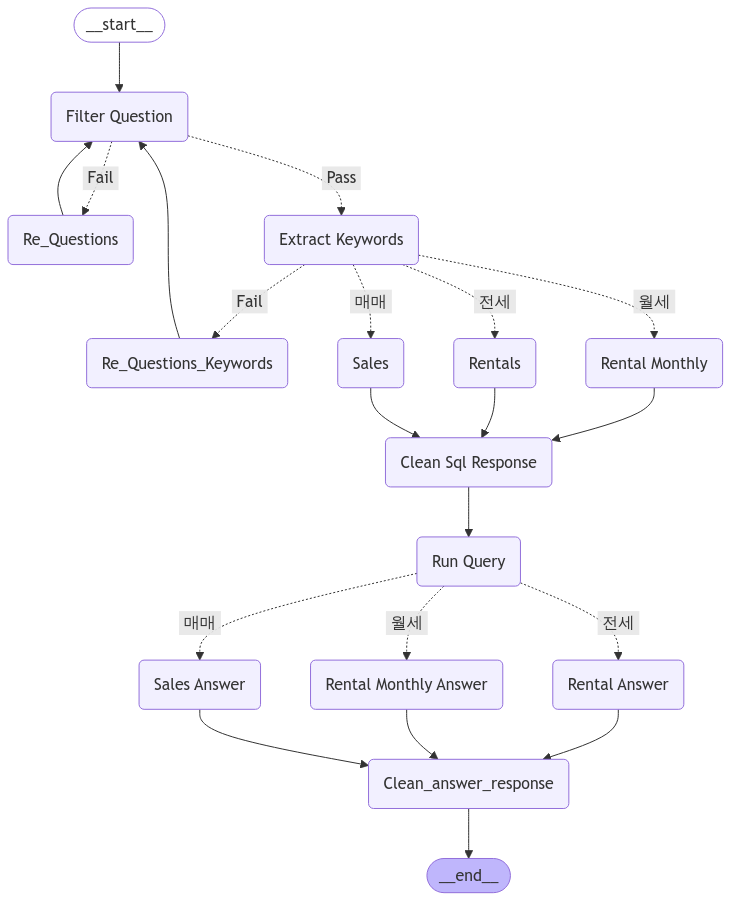

In [165]:
result = app.invoke({'messages': input()})

if result['query_answer'] == "검색 결과가 없습니다.":
        print(result['query_answer'])
else:
    for key, value in result['query_answer'].items():
        print("+++++++++++++++++++++++++++++++++")
        print(f'{key}')
        # 'price' 키 확인
        if 'price' in value and value['price']:  
            print(f"가격: {value['price']}")
        
        # 'monthly_rent' 키 확인
        elif 'monthly_rent' in value and value['monthly_rent']:  
            print(f"보증금: {value.get('deposit', 'N/A')}")
            print(f"월세: {value['monthly_rent']}")
        
        # 'deposit' 키 확인
        elif 'deposit' in value:  
            print(f"보증금: {value['deposit']}")
        print(f"정보: {value['description']}")
        print("+++++++++++++++++++++++++++++++++")
        print()


workflow_image = app.get_graph().draw_mermaid_png()
display(Image(workflow_image))

In [166]:
print(result['query_sql'])

SELECT 
    r.property_id,
    l.sigungu,
    p.description,
    r.deposit AS "보증금",
    r.monthly_rent AS "월세비",
    l.latitude,
    l.longitude
FROM rentals r
JOIN property_info p ON r.property_id = p.property_id
JOIN property_locations l ON p.property_location_id = l.property_location_id
WHERE l.sigungu LIKE '%강서구%'
AND r.rental_type = 'YEARLY'
AND CAST(REPLACE(r.monthly_rent, ',', '') AS INTEGER) <= 60 * 10000
ORDER BY CAST(REPLACE(r.deposit, ',', '') AS INTEGER) ASC, CAST(REPLACE(r.monthly_rent, ',', '') AS INTEGER) ASC
LIMIT 5;


In [167]:
print(result['messages'][-1])

content='강서구 월세60추천해줘' additional_kwargs={} response_metadata={} id='8658dcac-4517-42c7-bf6a-25e4f113ac07'


In [168]:
print(db.get_table_info())


CREATE TABLE addresses (
	address_id INTEGER NOT NULL, 
	area_name VARCHAR(100) NOT NULL, 
	latitude FLOAT, 
	longitude FLOAT, 
	created_at DATETIME, 
	PRIMARY KEY (address_id)
)


CREATE TABLE api_search_data (
	id INTEGER NOT NULL, 
	api_name VARCHAR(100) NOT NULL, 
	parameter VARCHAR(500), 
	response VARCHAR, 
	created_at DATETIME, 
	PRIMARY KEY (id)
)


CREATE TABLE chat_logs (
	id INTEGER NOT NULL, 
	user_uuid CHAR(36) NOT NULL, 
	session_id CHAR(36) NOT NULL, 
	message_type VARCHAR(4) NOT NULL, 
	message TEXT NOT NULL, 
	created_at DATETIME DEFAULT CURRENT_TIMESTAMP NOT NULL, 
	PRIMARY KEY (id), 
	FOREIGN KEY(user_uuid) REFERENCES users (uuid)
)


CREATE TABLE crime_stats (
	stat_id INTEGER NOT NULL, 
	address_id INTEGER, 
	reference_date VARCHAR(8), 
	total_population FLOAT, 
	crime_category VARCHAR(50) NOT NULL, 
	crime_subcategory VARCHAR(50) NOT NULL, 
	incident_count INTEGER NOT NULL, 
	crime_rate FLOAT, 
	created_at DATETIME, 
	PRIMARY KEY (stat_id), 
	FOREIGN KEY(address_